In [9]:
# Import Packages (Local Machine Only)
import copy
import geopandas as gpd
import json
import math
import numpy as np
import os
from osgeo import gdal
import pdal
import pdb
import pyproj
import requests
from shapely.geometry import shape, Point, Polygon, LineString
from shapely.ops import transform
import subprocess
import sys
import gpxpy
import pandas as pd
import matplotlib.pyplot as plt
import re
from scipy.interpolate import LinearNDInterpolator
from tqdm import tqdm

Now, set the necessary GDAL configuration options.

In [10]:
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_ENABLE_DEPRECATED_DRIVER_DODS', 'YES')

<a name="Define-Functions"></a>
### Define Functions

Several functions are provided in the cell below. These functions are necessary for successful execution of remainder of the notebook. Broadly, these functions provide the utility for the user to draw and area of interest (AOI) on an interactive map and construct the PDAL pipeline for getting the point cloud data from the Amazon Web Services EPT bucket, performing processing steps, producing DEMs, and saving the results. A description of the parameters are provided as docstrings in the function definitions.


**These functions can be modified as the user sees fit; however, they are designed to work with a simple execution of the below cell.**

In [11]:
def proj_to_3857(poly, orig_crs):
    """
    Function for reprojecting a polygon from a shapefile of any CRS to Web Mercator (EPSG: 3857).
    The original polygon must have a CRS assigned.

    :param poly: shapely polygon for user area of interest (AOI)
    :param orig_crs: the original CRS for the shapefile. It is stripped out during import_shapefile_to_shapely() method
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project_gcs = pyproj.Transformer.from_crs(orig_crs, wgs84, always_xy=True).transform
    project_wm = pyproj.Transformer.from_crs(orig_crs, web_mercator, always_xy=True).transform
    user_poly_proj4326 = transform(project_gcs, poly)
    user_poly_proj3857 = transform(project_wm, poly)
    return(user_poly_proj4326, user_poly_proj3857)

def gcs_to_proj(bbox):
    """
    Function for reprojecting polygon shapely object from geographic coordinates (EPSG:4326)
    to Web Mercator (EPSG: 3857)).

    :param poly: shapely polygon for user area of interest (AOI)
    """
    wgs84 = pyproj.CRS("EPSG:4326")
    web_mercator = pyproj.CRS("EPSG:3857")
    project = pyproj.Transformer.from_crs(wgs84, web_mercator, always_xy=True).transform
    user_poly_proj3857 = transform(project, bbox)
    return (user_poly_proj3857)


def build_pdal_pipeline(extent_epsg3857, usgs_3dep_dataset_names, pc_resolution, filterNoise = True,
                        savePointCloud = True, outCRS = 3857, pc_outName = 'pointcloud_colorized', pc_outType = 'laz'):

    """
    Build pdal pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage'
    in the final pdal pipeline. Each stages is appended to the 'pointcloud_pipeline' object to produce the final pipeline.

    Parameters:
    :param extent_epsg3857: Polygon for user-defined AOI in Web Mercator projection (EPS:3857)Polygon is generated
                            either through the 'handle_draw' methor or by inputing their own shapefile.
    :param usgs_3dep_dataset_names: List of name of the 3DEP dataset(s) that the data will be obtained. This parameter is set
                                determined through intersecttino of the 3DEP and AOI polys.
    :param pc_resolution: The desired resolution of the pointcloud based on the following definition:

                        Source: https://pdal.io/stages/readers.ept.html#readers-ept
                            A point resolution limit to select, expressed as a grid cell edge length.
                            Units correspond to resource coordinate system units. For example,
                            for a coordinate system expressed in meters, a resolution value of 0.1
                            will select points up to a ground resolution of 100 points per square meter.
                            The resulting resolution may not be exactly this value: the minimum possible
                            resolution that is at least as precise as the requested resolution will be selected.
                            Therefore the result may be a bit more precise than requested.

    :param filterNoise: Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    :param savePointCloud: Option to save (or not) the point cloud data. If savePointCloud == False,
           the pc_outName and pc_outType parameters are not used and can be any value.
    :param outCRS: Output coordinate reference systemt (CRS), specified by ESPG code (e.g., 3857 - Web Mercator)
    :param pc_outName: Desired name of file on user's local file system. If savePointcloud = False,
                  pc_outName can be in value.
    :param pc_outType:  Desired file extension. Input must be either 'las' or 'laz'. If savePointcloud = False,
                  pc_outName can be in value. If a different file type is requested,the user will get error.
    :raise Exception: If user passes in argument that is not 'las' or 'laz'.
    """
    readers = []
    for name in usgs_3dep_dataset_names:
        url = "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/{}/ept.json".format(name)
        reader = {
            "type": "readers.ept",
            "filename": str(url),
            "polygon": str(extent_epsg3857),
            "requests": 3,
            "resolution": pc_resolution
        }
        readers.append(reader)

    pointcloud_pipeline = {
        "pipeline":
            readers
    }

    if filterNoise == True:

        # Filter stage for class 7
        filter_stage_class7 = {
            "type": "filters.range",
            "limits": "Classification![7:7]"
        }

        # Filter stage for class 18
        filter_stage_class18 = {
            "type": "filters.range",
            "limits": "Classification![18:18]"
        }

        filter_ground = {
            "type": "filters.expression",
            "expression": "Classification == 2"
        }

        convert_coords = {
            "type":"filters.reprojection",
            "out_srs":"EPSG:4326"
        }

        # Append both filter stages to the pipeline separately
        pointcloud_pipeline['pipeline'].append(filter_stage_class7)
        pointcloud_pipeline['pipeline'].append(filter_stage_class18)
        pointcloud_pipeline['pipeline'].append(filter_ground)
        pointcloud_pipeline['pipeline'].append(convert_coords)

    if savePointCloud == True:

        if pc_outType == 'las':
            savePC_stage = {
                "type": "writers.las",
                "filename": str(pc_outName) + '.' + str(pc_outType)
            }
        elif pc_outType == 'laz':
            savePC_stage = {
                "type": "writers.las",
                "compression": "laszip",
                "scale_x":"0.0000001",
                "scale_y":"0.0000001",
                "scale_z":"0.01",
                "offset_x":"auto",
                "offset_y":"auto",
                "offset_z":"auto",
                "filename": str(pc_outName) + '.' + str(pc_outType)
            }
        else:
            raise Exception("pc_outType must be 'las' or 'laz'.")

        pointcloud_pipeline['pipeline'].append(savePC_stage)

    #print("pdal pipeline built successfully...")

    return pointcloud_pipeline


def build_raster_pipeline(pointcloud, raster):
    pointcloud_pipeline = {
        "pipeline":
            [pointcloud]
    }
    delaunay = {
        "type": "filters.delaunay"
    }
    faceraster = {
        "type": "filters.faceraster",
        "resolution": 0.0001
    }
    writer = {
        "type": "writers.raster",
        "filename": raster
    }
    pointcloud_pipeline['pipeline'].append(delaunay)
    pointcloud_pipeline['pipeline'].append(faceraster)
    pointcloud_pipeline['pipeline'].append(writer)

    #print("raster pipeline built successfully...")

    return pointcloud_pipeline

<a name="Data-Access-and-Processing"></a>
## Data Access and Processing
Now that we have the required modules imported and functions defined, we can proceed with defining our area of interest (AOI), accessing/processing the 3DEP data from the Amazon Web Services EPT bucket. 

<a name="Get-3DEP-Dataset-Boundary-Polygons"></a>
### Get 3DEP Dataset Boundary Polygons  
First, we will get the 3DEP dataset polygon boundaries to see if 3DEP data is currently available for our area of interest. An up-to-date version of the currently available 3DEP dataset boundaries are maintained by Hobu Inc. in the usgs-lidar Github repository https://github.com/hobuinc/usgs-lidar/. 

In the following cell, we use an API request to get the boundaries from the repository and save a local copy of these boundaries in geojson format. Next, we create a geopandas dataframe object to easily access the names, url, and point count of each dataset, and we use the ```gcs_to_proj()``` function to project each 3DEP polygon geometry to Web Mercator projection (EPSG: 3857), which is the native projection of the 3DEP data in the AWS S3 bucket.

In [12]:
# Get GeoJSON file for 3DEP outlines from URL

print("Requesting, loading, and projecting 3DEP dataset polygons...")

#request the boundaries from the Github repo and save locally.
url = 'https://raw.githubusercontent.com/hobuinc/usgs-lidar/master/boundaries/resources.geojson'
r = requests.get(url)
with open('resources.geojson', 'w') as f:
    f.write(r.content.decode("utf-8"))

with open('resources.geojson', 'r') as f:
    geojsons_3DEP = json.load(f)

#make pandas dataframe and create pandas.Series objects for the names, urls, and number of points for each boundary.
with open('resources.geojson', 'r') as f:
    df = gpd.read_file(f)
    names = df['name']
    urls = df['url']
    num_points = df['count']

#project the boundaries to EPSG 3857 (necessary for API call to AWS for 3DEP data)
projected_geoms = []
for geometry in df['geometry']:
        projected_geoms.append(gcs_to_proj(geometry))

geometries_GCS = df['geometry']
geometries_EPSG3857 = gpd.GeoSeries(projected_geoms)

print('Done. 3DEP polygons downloaded and projected to Web Mercator (EPSG:3857)')

Requesting, loading, and projecting 3DEP dataset polygons...
Done. 3DEP polygons downloaded and projected to Web Mercator (EPSG:3857)


<a name="Find-3DEP-Polygon(s)-Intersecting-AOI"></a>
### Find 3DEP Polygon(s) Intersecting AOI
Now that the user-specified AOI is defined, the following cell will determine the intersecting 3DEP dataset names and show the corresponding polygons on an interactive map.  `intersecting_polys` will be a list of the intersecting 3DEP dataset name(s), boundary(ies) in EPSG: 4326, boundary(ies) in EPSG: 3857, url(s), and the number of points in the entire 3DEP dataset(s). The dataset names will be used in the API request to the AWS EPT S3 bucket. A ratio of the total number of points and the area of the user-defined AOI will be used to estimate the total points within the AOI.

In [13]:
def get_gpx_data(file):
    with open(file, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    lat = [] # y
    lon = [] # x
    ele = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                lat.append(point.latitude)
                lon.append(point.longitude)
                ele.append(point.elevation)
    return LineString(list(zip(lon, lat, ele)))

def thicken(line, distance):
    lineb = gpd.GeoSeries([line], crs="EPSG: 4326")
    lineb: gpd.GeoSeries = lineb.to_crs(lineb.estimate_utm_crs()).buffer(distance, cap_style='round').to_crs("EPSG: 4326")
    return lineb.geometry.values[0]


In [14]:
def process_route(route, id):
    AOI_GCS = thicken(route, 5)
    AOI_EPSG3857 = gcs_to_proj(AOI_GCS)

    intersecting_polys = []

    for i,geom in enumerate(geometries_EPSG3857):
        if geom.intersects(AOI_EPSG3857):
            intersecting_polys.append((names[i], geometries_GCS[i], geometries_EPSG3857[i], urls[i], num_points[i]))

    # Find AOI center for plotting purposes
    centroid =  list(AOI_GCS.centroid.coords)[0]

    #add intersecting 3DEP polygon(s) to the map
    wlayer_3DEP_list = []
    usgs_3dep_datasets = []
    number_pts_est = []
    for i, poly in enumerate(intersecting_polys):
        usgs_3dep_datasets.append(poly[0])
        number_pts_est.append((int((AOI_EPSG3857.area/poly[2].area)*(poly[4]))))

    AOI_EPSG3857_wkt = AOI_EPSG3857.wkt

    #sum the estimates of the number of points from each 3DEP dataset within the AOI
    num_pts_est = sum(number_pts_est)

    #print(f'Your AOI at full resolution will include approximately {int(math.ceil(num_pts_est/1e6)*1e6):,} points. Select desired point cloud resolution.')

    pointcloud_resolution = 5.0
    pc_pipeline = build_pdal_pipeline(AOI_EPSG3857_wkt, usgs_3dep_datasets, pointcloud_resolution, filterNoise = True,
                            savePointCloud = True, outCRS = 3857,
                            pc_outName = f'GIS/pointcloud_{id}', pc_outType = 'laz')
    pc_pipeline = pdal.Pipeline(json.dumps(pc_pipeline))
    pc_pipeline.execute_streaming(chunk_size=1000000)
    raster_pipeline = build_raster_pipeline(pointcloud = f'GIS/pointcloud_{id}.laz', raster = f'GIS/raster_{id}.tif')
    raster_pipeline = pdal.Pipeline(json.dumps(raster_pipeline))
    raster_pipeline.execute()
    return f'GIS/raster_{id}.tif'


In [15]:
def world2Pixel(gt, x, y):
    ulX = gt[0]
    ulY = gt[3]
    xDist = gt[1]
    yDist = gt[5]
    rtnX = gt[2]
    rtnY = gt[4]
    col = int((x - ulX) / xDist)
    row = int((ulY - y) / yDist)
    return (row, col)

def redistribute_vertices(geom, distance):
    crs = 'EPSG: 4326'
    gs = gpd.GeoSeries([geom], crs=crs)
    new_crs = gs.estimate_utm_crs()
    gs = gs.to_crs(new_crs)
    new_geom = gs[0]
    num_vert = int(round(new_geom.length / distance))
    if num_vert == 0:
        num_vert = 1
    interp_geom = LineString([new_geom.interpolate(float(n) / num_vert, normalized=True) for n in range(num_vert + 1)])
    return gpd.GeoSeries([interp_geom], crs=new_crs).to_crs(crs)[0]

def interpolate_vertices(geom):
    crs = 'EPSG: 4326'
    gs = gpd.GeoSeries([geom], crs=crs)
    new_crs = gs.estimate_utm_crs()
    gs = gs.to_crs(new_crs)
    df = pd.DataFrame(gs[0].coords, columns=['x', 'y', 'z']).replace(-9999, np.nan)
    real_df = df.dropna(axis=0)
    f = LinearNDInterpolator((real_df['x'].values, real_df['y'].values), real_df['z'].values)
    coords = np.array([df['x'].values, df['y'].values, f(df['x'].values, df['y'].values)])
    df = pd.DataFrame({'x': coords[0], 'y': coords[1], 'z': coords[2]}).interpolate(method='linear')
    df = (df.interpolate(method="nearest", order=3, limit=None,limit_direction=None)
            .fillna(df.interpolate(method="spline", order=3, limit=None, limit_direction='both'))
         )
    new_geom = LineString(np.array([df['x'].values, df['y'].values, df['z'].values]).T)
    return gpd.GeoSeries([new_geom], crs=new_crs).to_crs(crs)[0]

def create_route_df(route, raster_file):
    route = redistribute_vertices(route, 5)
    raster = gdal.Open(raster_file)
    band = raster.GetRasterBand(1).ReadAsArray().astype(np.float64)
    gt = raster.GetGeoTransform()
    points = []
    for x, y, ele in route.coords:
        row, col = world2Pixel(gt, x, y)
        z = band[-row, col]
        if z < -1000:
            z = -9999
        points.append((x, y, float(z)))

    interp_route = interpolate_vertices(LineString(points))

    return gpd.GeoDataFrame(index=[0], crs='EPSG: 4326', geometry=[interp_route])

In [16]:
dfs = []

for filename in tqdm(os.listdir('EarthRoutes')):
    if filename.endswith('.gpx'):
        try:
            route = get_gpx_data("EarthRoutes/"+filename)
            id = int(re.search(r"(\d+)", filename).group(1))
            raster_file = process_route(route, id)
            df = create_route_df(route, raster_file)
            df['id'] = id
            dfs.append(df)
        except Exception as exc:
            print(f"Failed on {filename} with exception: {exc}")

dfs = gpd.GeoDataFrame(pd.concat(dfs, ignore_index = True), crs=dfs[0].crs)

  2%|▏         | 6/302 [01:20<1:26:26, 17.52s/it]

Failed on route_7003838.gpx with exception: filters.range: Invalid dimension name in 'limits' option: 'Classification'.


  3%|▎         | 8/302 [01:22<45:52,  9.36s/it]  

Failed on route_593708.gpx with exception: vector
Failed on route_5392275.gpx with exception: filters.range: Invalid dimension name in 'limits' option: 'Classification'.


  3%|▎         | 10/302 [02:07<1:01:59, 12.74s/it]


KeyboardInterrupt: 

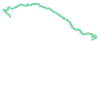

In [ ]:
dfs['geometry'][0]

In [188]:
dfs.explore()

In [177]:
dfs

,geometry,id
0,"LINESTRING (-109.23205 38.48554, -109.23204 38...",4670265


In [34]:
dfs['elevation'].min()

np.float64(1205.4521607522374)

In [65]:
dfs['geometry'][0].coords[0]

(-109.232048, 38.485545, -9999.0)

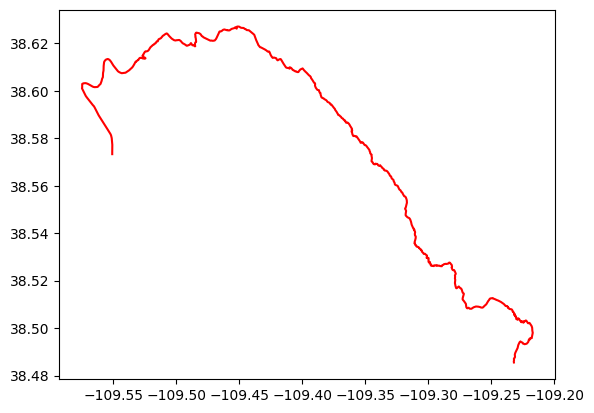

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot()

# Create the scatter plot
xs = dfs['longitude'].to_numpy()
ys = dfs['latitude'].to_numpy()
ax.plot(xs, ys, c='r')

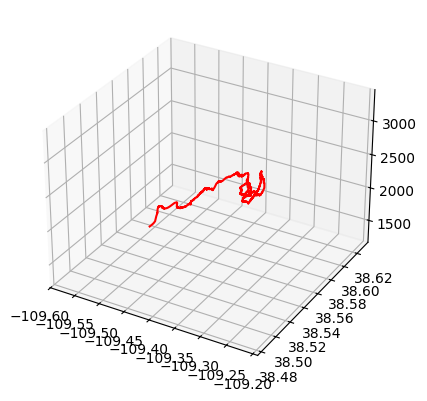

In [ ]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Create the scatter plot
xs = dfs['longitude'].to_numpy()
ys = dfs['latitude'].to_numpy()
zs = dfs['elevation'].to_numpy()
ax.plot(xs, ys, zs, c='r')